In [1]:
import os
from pathlib import Path
import calendar

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests as rq

# for aWhere API
from header import AWhereAPI
from secret_codes import *

api_key = API_KEY
api_secret = API_SECRET

In [2]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

In [3]:
# Set variables for aWhere API call 

# General endpoint
endpt = "https://api.awhere.com"

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

In [19]:
# Load area of interest into gpd

# Create path to home
home = str(Path.home())

# Create path to Siskiyou geojson since csv crashes Jupyter
path_to_siskiyou = os.path.join(
    home, "Desktop", "drought-tracker", "data", "TIGER", "siskiyou.geojson")

# Create df with 1 county (Siskiyou)
siskiyou = gpd.read_file(path_to_siskiyou)

# Convert into CRS
siskiyou = siskiyou.to_crs("EPSG:4236")

C:\Users\dphil\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [20]:
def create_awhere_grid(aoi, out_crs, calc_crs):
    """
    Parameters
    ----------
    aoi: Geopandas GeoDataFrame
        One-element GeoDataFrame containing area over which
        to draw grid
    
    out_crs: numeric string
        String of EPSG code for exported GDF
    
    calc_crs: numeric string
        String of EPSG code for CRS used
        to calculate grid. CRS must have units of meters
        
    Returns
    -------
    GeoDataFrame containing 9km x 9km cells
    """   
    
    # Reproject aoi to CRS using meters for aWhere grid cells
    aoi = aoi.to_crs(f'epsg:{calc_crs}')
    
    # Get x and y min and max from total boundaries
    xmin, ymin, xmax, ymax = aoi.total_bounds
    
    # Set side of grid cell to 9 km
    side = 9000
    
    # Create x values for x points for rows
    x_range = np.arange(int(np.floor(xmin)), int(np.ceil(xmax)), side)
    
    # Create y values
    y_range = np.arange(int(np.floor(ymin)), int(np.floor(ymax)), side)
    
    # Create empty list to hold grid cells
    polygons = []
    
    for x in x_range:
        for y in y_range:
            polygons.append(Polygon([(x,y), (x+side, y), (x+side, y+side), (x,y+side)]))
            
    grid = gpd.GeoDataFrame({'geometry': polygons})
    
    grid.crs = f'EPSG:{calc_crs}'
    
    # Convert to out_crs
    grid = grid.to_crs(f"EPSG:{out_crs}")
    
    return grid

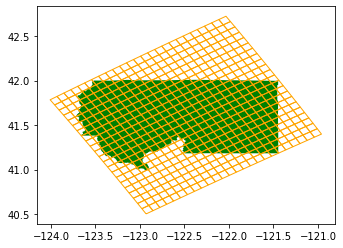

In [23]:
# Create grid polygon
grid = create_awhere_grid(aoi=siskiyou,
                          out_crs='4236',
                          calc_crs='2019')

# Add centroid column
grid['centroid'] = grid.geometry.apply(lambda poly: poly.centroid)

# Check to see if everything looks correct
fig, ax = plt.subplots()
grid.plot(color="none", linewidth=1, edgecolor='orange', ax=ax, zorder=3)
siskiyou.plot(color='green', zorder=2, ax=ax)

plt.show()

In [122]:
def call_api(lat, lon, start_date, end_date):
    
        # URL to historical agronomics (norms)
        hist_ag_url = f"/v2/agronomics/locations/{lat},{lon}/agronomicvalues/{start_date},{end_date}"

        # Endpoint suffix to get all accumulations
        url_append = "?properties=accumulations"

        # Full URL, endpt is defined up top
        full_url = endpt + hist_ag_url + url_append

        # Get JSON
        ag_norms_json = rq.get(full_url, headers=agro_header).json()
        
        return ag_norms_json

In [28]:
def get_ppet(grid_df, start_date, end_date, drop_null=False, testing=False):
    """
    Paraemeters
    -----------
    grid_df: Geopandas GeoDataFrame
        Contains gridded area to fetch argonomics values for

    start_date: string
        Format "YYYY-MM-DD"

    end_date: string
        Format "YYYY-MM-DD"

    drop_null: boolean (optional)
        Drop grid cells that have null values returned from
        API request for agronomics data. Often null values 
        result from grid cell lying in a body of water.

    testing: boolean (optional)
        Returns sample P/PET values for each grid cell 
        from 0 - 30 mm. Used for testing; bypasses API call.

    Returns
    -------
    grid_df: Geopandas GeoDataFrame
        Contains gridded input area with requested values.

    """

    # For testing, generate random values for each cell
    if testing == True:
        grid_df['test_ppet'] = [np.random.randint(
            0, 30) for i in range(0, grid.shape[0])]

        return grid_df

    # Add P/PET column if it does not exist and initialize to 0
    if 'ppet' not in grid_df.columns:
        grid_df = grid_df.assign(ppet=0)

    # Iterate thru rows (cells) in gdf
    for index, row in grid_df.iterrows():
        
        print(f"On row {index + 1} of {grid.shape[0]}")
        # Get centroid coordinates from each cell to pass to API
        lat = round(row.centroid.y, 5)
        lon = round(row.centroid.x, 5)

        # Get JSON
        ag_norms_json = call_api(lat, lon, start_date, end_date)

        # Try to pull data from return JSON
        try:
            
            vals = ag_norms_json.get('accumulations').get('ppet')
            
            grid_df.loc[index, 'ppet'] = vals 

        except:
            grid_df.loc[index, 'ppet'] = np.nan

        # Drop null cells if requested
        if drop_null == True:
            grid_df = grid_df[grid_df.ppet.isnull() == False]

    return grid_df


ppet_grid = get_ppet(grid_df=grid,
                     start_date="2020-04-01",
                     end_date="2020-04-30",
                     drop_null=False,
                     testing=False)

On row 1 of 550
On row 2 of 550
On row 3 of 550
On row 4 of 550
On row 5 of 550
On row 6 of 550
On row 7 of 550
On row 8 of 550
On row 9 of 550
On row 10 of 550
On row 11 of 550
On row 12 of 550
On row 13 of 550
On row 14 of 550
On row 15 of 550
On row 16 of 550
On row 17 of 550
On row 18 of 550
On row 19 of 550
On row 20 of 550
On row 21 of 550
On row 22 of 550
On row 23 of 550
On row 24 of 550
On row 25 of 550
On row 26 of 550
On row 27 of 550
On row 28 of 550
On row 29 of 550
On row 30 of 550
On row 31 of 550
On row 32 of 550
On row 33 of 550
On row 34 of 550
On row 35 of 550
On row 36 of 550
On row 37 of 550
On row 38 of 550
On row 39 of 550
On row 40 of 550
On row 41 of 550
On row 42 of 550
On row 43 of 550
On row 44 of 550
On row 45 of 550
On row 46 of 550
On row 47 of 550
On row 48 of 550
On row 49 of 550
On row 50 of 550
On row 51 of 550
On row 52 of 550
On row 53 of 550
On row 54 of 550
On row 55 of 550
On row 56 of 550
On row 57 of 550
On row 58 of 550
On row 59 of 550
On row

On row 463 of 550
On row 464 of 550
On row 465 of 550
On row 466 of 550
On row 467 of 550
On row 468 of 550
On row 469 of 550
On row 470 of 550
On row 471 of 550
On row 472 of 550
On row 473 of 550
On row 474 of 550
On row 475 of 550
On row 476 of 550
On row 477 of 550
On row 478 of 550
On row 479 of 550
On row 480 of 550
On row 481 of 550
On row 482 of 550
On row 483 of 550
On row 484 of 550
On row 485 of 550
On row 486 of 550
On row 487 of 550
On row 488 of 550
On row 489 of 550
On row 490 of 550
On row 491 of 550
On row 492 of 550
On row 493 of 550
On row 494 of 550
On row 495 of 550
On row 496 of 550
On row 497 of 550
On row 498 of 550
On row 499 of 550
On row 500 of 550
On row 501 of 550
On row 502 of 550
On row 503 of 550
On row 504 of 550
On row 505 of 550
On row 506 of 550
On row 507 of 550
On row 508 of 550
On row 509 of 550
On row 510 of 550
On row 511 of 550
On row 512 of 550
On row 513 of 550
On row 514 of 550
On row 515 of 550
On row 516 of 550
On row 517 of 550
On row 518

In [ ]:
#ppet_grid.drop(columns=["centroid"], inplace=True)

#siskiyou_out_path = os.path.join(home, "Desktop", "drought-tracker", "data", "awhere", "siskiyou.geojson")

#ppet_grid.to_file(siskiyou_out_path, driver="GeoJSON")

#ppet_grid = gpd.read_file(siskiyou_out_path)

In [60]:
def binary_threshold(gdf, daily_acc_ppet_threshold, month, year):
    
    # Find monthly accumulated P/PET
    days_in_month = calendar.monthrange(year, month)[1]
    
    # Calculate monthly accumulated P/PET based on user's threshold
    monthly_acc_ppet = days_in_month * daily_acc_ppet_threshold
    
    # Add Boolean flag column if meets threshold
    gdf['meet_thresh'] = gdf['ppet'].apply(lambda x: 1 if x >= monthly_acc_ppet else 0)
    
    return gdf

binary_grid = binary_threshold(gdf=ppet_grid, 
                        daily_acc_ppet_threshold = 0.4, 
                        month=4, 
                        year=2020)

In [61]:
def to_convex_hull(gdf, crs):
    
    # Drop all rows that do not meet threshold
    meet_thresh_only = gdf[gdf.meet_thresh == 1]
    
    # Dissolve polygons that meet threshold
    meet_thresh_dissolve = meet_thresh_only.dissolve(by='meet_thresh')
    
    # Explode polygons so that there are unique contiguous areas
    exploded = meet_thresh_dissolve.explode()

    # Drop multi-index outer level generated from dissolve
    exploded = exploded.droplevel(0)
    
    # Add area column
    exploded["sqkm"] = exploded['geometry'].area/ 10**6
    
    # Get largest polygon
    largest = exploded[exploded.sqkm == exploded.sqkm.max()]
    
    # Generate convex hull
    hull_largest = largest.convex_hull

    # Convert to gdf
    hull = gpd.GeoDataFrame(hull_largest, crs=f'epsg:{crs}')

    # Rename column '0' to 'geometry'
    hull.rename(columns={0:"geometry"}, inplace=True)
    
    return hull

In [107]:
hull = to_convex_hull(binary_grid, 4326)

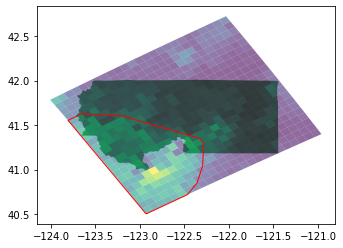

In [108]:
fig, ax = plt.subplots()

hull.plot(ax=ax, color='none', edgecolor='red', zorder=4)
binary_grid.plot(column='ppet', ax=ax, alpha=0.6, zorder=3)
siskiyou.plot(color='green', alpha=0.9, ax=ax)

plt.show()

In [115]:
def proportional_split(grid_gdf, hull_gdf, crs):
    
    grid_gdf = grid_gdf.to_crs(f"epsg:{crs}")
    
    hull_gdf = hull_gdf.to_crs(f"epsg:{crs}")
    
    # Set summary variables to 0
    inter_area_run_sum = 0
    
    # This is a list to more easily calculate average (using sum then len)
    inter_ppet_run_sum = []
    
    for index, row in grid_gdf.iterrows():
        
        if row.geometry.intersects(hull_gdf.geometry[0]):
            
            intersect_area = row.geometry.intersection(hull_gdf.geometry[0]).area
            
            # Find the proportional split of grid cell's P/PET
            proportional_ppet = (intersect_area / row.geometry.area) * row.ppet
            
            # Append it to the list
            inter_ppet_run_sum.append(proportional_ppet)
    
    # Find average P/PET per cell
    inter_ppet = round((sum(inter_ppet_run_sum) / len(inter_ppet_run_sum)), 3)
    
    print(f"Total droughted area: {hull_gdf.geometry[0].area}")

    print(f"Average P/PET in droughted area: {inter_ppet}")
    
proportional_split(binary_grid, hull, "2019")

Total droughted area: 12473999999.999857
Average P/PET in droughted area: 11.965


In [124]:
start_year = 2010
end_year = 2012

years_range = np.arange(start_year, end_year + 1)

returned_data = []

for year in years_range:
    # get grid
    # fill cells with values for that year
    # binary/boolean classify
    # convex hull
    # (proportional split)
    # add convex_hull, proportional_split as tuple    
    
    pass
# create gdf from returned_data with idx = year, geom=convex_hull, data=proportional_split
# find centroids of hulls
# plot centroids
